### Using Symbolics

#####   Dependents

In [ ]:
using Symbolics, SymbolicUtils

### Using symbolics to generate system matrix
First we will look at a turbine

In [ ]:
#   State variables
@variables Ti Pi ṁi To Po ṁo Ẇo 

#   Component parameters, assuming cp = constant (implies that k is also constant)
#   For consistency, Im assuming that rp is in the format Pmax/Pmin (P1/P2)
@variables rp k cp η_isen cp

equations = [
    ṁi ~ ṁo,
    Po ~ rp * Pi,
    To ~ Ti - η_isen * Ti * (1 - (1/rp) ^ ((k-1)/k)),
    Ẇo ~ ṁo * cp * To - ṁi * cp * Ti]

In [ ]:
# Symbolics.build_function(equations, [ṁi, Ti, Pi, rp, k, η_isen, cp])
uknowns = [ṁo, Po, To, Ẇo]
Symbolics.solve_for(equations, uknowns)



## More general case, 
#### What happens if we create a universal control volume system of equations and symbolically simplify based on the component
#### What are the state variable required?

In [ ]:
#   Universal SISO CV so we account for:
#       Time: D =  d/dt
@variables t
D = Symbolics.Differential(t)

#   Energy of the control volume
@variables ΔE_cv
Ė_cv = D(ΔE_cv)

# Energy Balance Terms
#   Thermal         
#       Qh, Heat transfered in from Source @ Th
#       Qc, Heat transfered to a Source @ Tc
@variables Qh Qc Th Tc
#   Sign convention, Qnet = Qin
Q = Qh - Qc
Q̇ = D(Q)

#   Work Terms
@variables Wout Win
#   Sign convention, W = Wout - Win
W = Wout - Win
Ẇ = D(W)

#   Mass and Mass Flow Rate
@variables ΔM_cv m_i m_o          # mass in mass_out
ṁ_i = D(m_i)
ṁ_o = D(m_o)
M_bal = ΔM_cv ~ m_i - m_o
Ṁ_bal = D(ΔM_cv) ~ ṁ_i - ṁ_o

#   Kinetic Energy
@variables V_i V_o  ΔKE ΔKĖ # velocity
KE_bal = ΔKE ~ (m_i * V_i^2/2 - m_o * V_o^2/2)
KĖ_bal = ΔKĖ ~ (ṁ_i * V_i^2/2 - ṁ_o * V_o^2/2)

#   Potential Energy
@variables  gz_o  gz_i  ΔPE ΔPĖ # velocity
PE_bal = ΔPE ~ (m_i * gz_i - m_o * gz_o)
PĖ_bal = ΔPĖ ~ (ṁ_i * gz_i - ṁ_o * gz_o)

#   Internal Energy Flow Work
@variables u_i P_i v_i u_o P_o v_o ΔH ΔḢ
h_bal = ΔH ~ m_i * (u_i + P_i * v_i) - m_o * (u_o + P_o * v_o)
ḣ_bal = ΔḢ ~ ṁ_o * (u_i + P_i * v_i) - ṁ_o * (u_o + P_o * v_o)

#   Component parameters, assuming cp = constant (implies that k is also constant)
#   For consistency, Im assuming that rp is in the format Pmax/Pmin (P1/P2)

# Unsteady Energy Balance
energy_eq = [
    M_bal,
    KE_bal,
    PE_bal,
    h_bal,
    ΔE_cv ~ Q - W + ΔH + ΔKE + ΔPE,
    Ṁ_bal,
    KĖ_bal,
    PĖ_bal,
    ḣ_bal,
    Ė_cv ~ Q̇ - Ẇ + ΔḢ + ΔKĖ + ΔPĖ
]


# second law
@variables s_i s_o S_gen ΔS_cv 
Ṡ_cv = D(ΔS_cv)
Ṡ_gen = D(S_gen)

entropy_eq = [
    ΔS_cv ~ S_gen + Qh/Th + m_i * s_i - m_o * s_o - Qc/Tc
    Ṡ_cv ~ Ṡ_gen + D(Qh)/Th - D(Qc)/Tc + ṁ_i * s_i - ṁ_o * s_o]

CV_equations = vcat(energy_eq,entropy_eq)

### Lets see if we can use those to work back to turbine equations

In [ ]:
#   State variables
@variables T_i T_o

#   Component parameters, assuming cp = constant (implies that k is also constant)
#   For consistency, Im assuming that rp is in the format Pmax/Pmin (P1/P2)
@variables rp η_isen cp cv
R = cp - cv
k = cp + cv

ideal_gas_eq = [
    v_i ~ R*T_i/P_i,
    v_o ~ R*T_o/P_o,
    u_i - u_o ~ cv * (T_i - T_o)]


turbine_equations = [
    ṁ_i ~ ṁ_o,
    P_o ~ rp * P_i,
    T_o ~ T_i - η_isen * T_i * (1 - (1/rp) ^ ((k-1)/k)),
    Ẇ ~ ṁ_o * cp * T_o - ṁ_i * cp * T_i,
    Win ~ 0,
    V_i - V_o ~ 0,
    gz_i - gz_o ~ 0,
    Qh ~ 0,
    Qc ~ 0,
    ]

turb_cv = vcat(CV_equations,turbine_equations, ideal_gas_eq)

uknowns = [ṁ_o,T_o, P_o, u_o, Ẇ, Ė_cv]
knowns = [u_i; T_i;P_i; v_i; gz_i; V_i; cp; cv; ṁ_i; s_i]
# Symbolics.solve_for(turb_cv, uknowns)
# Symbolics.solve_for(turb_cv,uknowns)
# Symbolics.simplify(turb_cv)
# display(turb_cv[1])


In [ ]:
ideal_gas_dict = Dict(
    v_i => R*T_i/P_i,
    v_o => R*T_o/P_o,
    u_o => cv  * T_o,
    u_i => cv * T_i)

to_zero = Dict(
    Qh => 0, 
    Qc => 0, 
    Win => 0)


stead_flow_dict = Dict(
    M_bal.lhs => 0,
    Ṁ_bal.lhs => 0
)

NO_KE = Dict(
    KE_bal.lhs => 0,
    KĖ_bal.lhs =>0
)

NO_PE = Dict(
    PE_bal.lhs => 0,
    PĖ_bal.lhs => 0
)

turb_relations = [
    P_o ~ rp * P_i,
    T_o ~ T_i - η_isen * T_i * (1 - (P_o/P_i) ^ ((k-1)/k)),
    Ẇ ~ ṁ_o * cp * T_o - ṁ_i * cp * T_i,
    Ṡ_gen ~ Ẇ * (1/η_isen-1)
]

Turb = vcat(CV_equations,turb_relations)

# simplify(substitute(substitute(CV_equations, ideal_gas_dict,), to_zero,))
# test_dict = Dict(ΔPE => 0, ΔKE => 0, ΔM_cv =>0)
test_dict = Dict((gz_i - gz_o) => 0, (ṁ_i - ṁ_o) => 0)
Turb = simplify(substitute(Turb,NO_KE,))
Turb = simplify(substitute(Turb,NO_PE,))
Turb = simplify(substitute(Turb,stead_flow_dict,))
Turb = simplify(substitute(Turb,ideal_gas_dict,))
Turb = simplify(substitute(Turb,to_zero,))


# uknowns = [ṁ_o,T_o, P_o, u_o, Ẇ, Ė_cv]
# knowns = [m_i;ṁ_i; V_i; T_i; P_i; gz_i; V_i; cp; cv; ṁ_i; s_i];


#### TRANSIENT DYNAMICS

In [ ]:
using DifferentialEquations
function vessel!(dvt,x,t,p)  
    #q,qf,Tf)
#   Inputs
#   qf = inlet flow rate (m3/s)
#   q  = outlet flow rate m3/s_i
#   Tf = inlet temperature

    q = p[1]
    qf = p[2]
    Tf = p[3]

    V = x[1]
    T = x[2]

    dvt[1] = (qf - q)   #volume
    dvt[2] = (qf*Tf-q*T)/V - T*dVdt/V
end


In [ ]:

V0 = 1.0
T0 = 35
y0 = [V0,T0]

time = LinRange(0,10,100)  # time vector
qf = vcat(ones(50)*5.2, ones(50)*5.1)
qout = 5.0*ones(100)


refvec = ones(100)
Tf = refvec .* 300
Tf[70:end] .= 325

Vol = refvec .* V0
Temp = refvec .* T0

for (idx,t) in enumerate(time)

    if idx == length(time)
        return
    end
    
    params = [qout[idx],qf[idx],Tf[idx]]
    ts = (time[idx],time[idx+1])

    prob = ODEProblem(vessel!,y0,ts,params)
    sol = solve(prob,Tsit5())
    Vol[idx+1]  = sol[1]
    Temp[idx+1] = sol[2]

    y0 .= sol
end

data = hcat(t,qf,q,Tf,V,T)




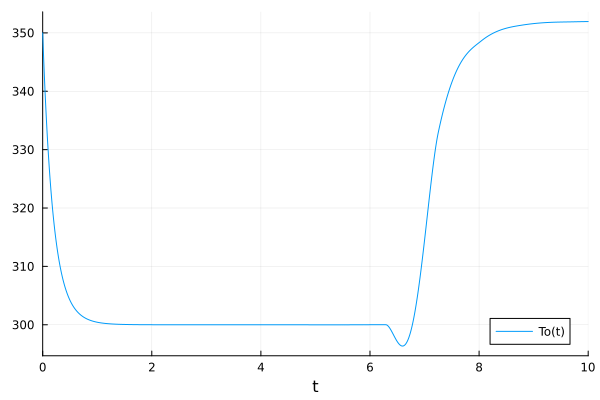

In [137]:
using ModelingToolkit, OrdinaryDiffEq, Plots, DifferentialEquations

@variables t To(t) V(t) qf(t) q(t) Tf(t)
D = Differential(t)


qfun(t) = t > 5.0 ? 5.10 : 5.20
Tfeed(t) = t > 7.0 ? 352 : 300
qou(t) = 5.0

@register_symbolic qfun(t)
@register_symbolic Tfeed(t)
@register_symbolic qou(t)

eqs = [qf ~ qfun(t),
        Tf ~ Tfeed(t),
        q ~ qou(t),
        D(V) ~ qf - q,
        D(To) ~ (qf*Tf-q*To)/V - To*D(V)/V]


@named sys = ODESystem(eqs)
sys = structural_simplify(sys)

u0 = [To =>350
    V => 1.0]

prob = ODEProblem(sys, u0, (0.0, 10.0))

plot(solve(prob), vars = To)


In [ ]:
using ModelingToolkit, OrdinaryDiffEq, Plots, DifferentialEquations

@variables t Tc(t) Th(t) V(t) Ch(t) Cc(t) Tci(t) Thi(t)
D = Differential(t)



qfun(t) = t > 5.0 ? 5.10 : 5.20
Tfeed(t) = t > 7.0 ? 352 : 300
qou(t) = 5.0

@register_symbolic qfun(t)
@register_symbolic Tfeed(t)
@register_symbolic qou(t)

eqs = [qf ~ qfun(t),
        Tf ~ Tfeed(t),
        q ~ qou(t),
        D(V) ~ qf - q,
        D(To) ~ (qf*Tf-q*To)/V - To*D(V)/V]


@named sys = ODESystem(eqs)
sys = structural_simplify(sys)

u0 = [To =>350
    V => 1.0]

prob = ODEProblem(sys, u0, (0.0, 10.0))

plot(solve(prob), vars = To)


In [ ]:
using ModelingToolkit, OrdinaryDiffEq, Plots, DifferentialEquations
@parameters m cp
@variables t Q̇(t) T(t)

D = Differential(t)

qfun(t) = t < 30 ? 4.28 * t/30 : 4.28
@register_symbolic qfun(t)

eqs = [
    D(T) ~ Q̇/(m*cp),
    Q̇ ~ qfun(t)
]

u0 = [T => 18,
        Q̇ => 0.0]

p = [m => 3.0,
    cp => 4.182
]
@named sys = ODESystem(eqs)
sys = structural_simplify(sys)


prob = ODEProblem(sys, u0, (0.0, 120.0), p)
sol = solve(prob)
plot(sol, vars = T)



## USING MODELING TOOLKIT
#### Defining domains and energy ports

In [ ]:
using ModelingToolkit, OrdinaryDiffEq, Plots, DifferentialEquations
@variables t

@connector function FlowPin(; name)
    sts = @variables T(t)=300.0 P(t)=20.0 ṁ(t)=1.0 [connect = Flow]
    ODESystem(Equation[], t, sts, []; name = name)
end

@component function FlowPort(; name)
    @named fp = FlowPin()
    @named fn = FlowPin()
    sts = @variables T(t) = 1.0 P(t)=1.0 ṁ(t)=1.0
    eqs = [ T ~ fp.T - fn.T
            P ~ fp.P - fn.P
            0 ~ fp.ṁ - fn.ṁ
            ṁ ~ fp.ṁ]
    compose(ODESystem(eqs, t, sts, []; name = name), fp, fn)
end

@connector function HeatPin(; name)
    sts = @variables Q̇(t) = 1.0
    ODESystem(Equation[], t, sts, []; name = name)
end

@component function HeatPort(; name)
    @named qp = HeatPin()
    @named qn = HeatPin()
    sts = @variables Q̇(t) = 1.0
    eqs = [0 ~ qp.Q̇ - qn.Q̇
            Q̇ ~ qp.Q̇]
    compose(ODESystem(eqs, t, sts, []; name = name), qp, qn)
end

@connector function WorkPin(; name)
    sts = @variables Ẇ(t) = 1.0
    ODESystem(Equation[], t, sts, []; name = name)
end

@component function WorkPort(; name)
    @named wp = WorkPin()
    @named wn = WorkPin()
    sts = @variables Ẇ(t) = 0.0
    eqs = [0 ~ wp.Ẇ - wn.Ẇ
            Ẇ ~ wp.Ẇ]
    compose(ODESystem(eqs, t, sts, []; name = name), wp, wn)
end

@named flowport =FlowPort()
@unpack T,P,ṁ=flowport

@named heatport =HeatPort()
@unpack Q̇ = heatport

@named workport =WorkPort()
@unpack Ẇ = workport

## Components

#### Grounding elements

In [ ]:
@component function FlowGround(; name)
    @named fg = FlowPin()
    eqs = [fg.P ~ 0,
        fg.T ~ 0,
        fg.ṁ ~ 0]
    compose(ODESystem(eqs, t, [], []; name = name), fg)
end

@component function HeatGround(; name)
    @named hg = HeatPin()
    eqs = [hg.Q̇ ~ 0]
    compose(ODESystem(eqs, t, [], []; name = name), hg)
end

@component function WorkGround(; name)
    @named wg = WorkPin()
    eqs = [wg.Ẇ ~ 0]
    compose(ODESystem(eqs, t, [], []; name = name), wg)
end

#### Sources

In [ ]:
@component function FlowReservoir(; name, Press = 10.0, Temp = 300.0)
    @named flowport = FlowPort()
    @unpack T,P = flowport
    ps = @parameters Ti = Temp Pi = Press
    eqs = [
        T~Ti,
        P~Pi
    ]
    extend(ODESystem(eqs, t, [], ps; name = name), flowport)
end

@component function MassFlowSource(; name, Ṁ = 1.0)
    @named flowport = FlowPort()
    @unpack ṁ = flowport
    ps = @parameters Ṁ = Ṁ
    eqs = [
        Ṁ ~ ṁ,
    ]
    extend(ODESystem(eqs, t, [], ps; name = name), flowport)
end

@component function HeatSource(; name, q̇ = 1.0)
    @named heatport = HeatPort()
    @unpack Q̇ = heatport
    ps = @parameters q̇ = q̇
    eqs = [
        Q̇ ~ q̇,
    ]
    extend(ODESystem(eqs, t, [], ps; name = name), heatport)
end

#### Elements

In [127]:
@component function HeaterEl(; name, UA = 6000, Tamb = 1000, m = 100)
    @named flowport = FlowPort()
    @named heatport = HeatPort()
    @unpack T, P, ṁ = flowport
    @unpack Q̇ = heatport
    cp = 5192
    D = Differential(t)
    eqs = [
        D(T) ~ (ṁ*cp)*T - Q̇
    ]
    extend(extend(ODESystem(eqs, t, [], []; name = name), flowport) , heatport)
end

@component function flow_continuity(; name)
    @named flowport = FlowPort()
    @unpack T, P, ṁ = flowport
    cp = 5192
    eqs = [
        T ~ flowport.fp.T - flowport.fn.T
        P ~ flowport.fp.P - flowport.fn.P
        ṁ ~ flowport.fp.ṁ
    ]
    extend(ODESystem(eqs, t, [], []; name = name), flowport) 
end

@component function piping(; name, R = .01)
    @named flowport = FlowPort()
    @unpack T, P, ṁ = flowport
    cp = 5192
    
    D = Differential(t)

    eqs = [
        P ~ R*ṁ
        T ~ 0
    ]
    extend(ODESystem(eqs, t, [], []; name = name), flowport) 
end



methods(compose)
methods(extend)
methods(connect)

# 1 method for generic function "connect":
[1] connect(sys1, sys2, syss...) in Symbolics at C:\Users\harvey\.julia\packages\Symbolics\3jLt1\src\equations.jl:8

In [136]:
@named flowG = FlowGround(name = :flowground);
@named mflowsource = MassFlowSource(name = :mflow, Ṁ = 120);
@named flowres = FlowReservoir(name = :flowres, Press = 25.0, Temp = 300);
@named pipes = piping();
@named cont_el = flow_continuity();

@named heatG    = HeatGround(name = :heatground);
@named qsource  = HeatSource(name = :weball,q̇ = 100);
@named heater   = HeaterEl(name = :heat);

# flow_eq = [connect(flowG.fg , flowres.fp),
#             connect(flowres.fn, mflowsource.fp),
#             connect(mflowsource.fn, heater.fp),
#             connect(heatG.hg, qsource.qp),
#             connect(qsource.qn,heater.qp),
#             connect(heater.fn, cont_el.fp),
#             connect(cont_el.fn,flowres.fp)];
            
# flow_eq = [connect(flowG.fg , mflowsource.fp),
#             connect(mflowsource.fn, flowres.fp),
#             connect(flowres.fn, pipes.fp),
#             connect(pipes.fn, heater.fp),
#             connect(heater.fn, cont_el.fp),
#             connect(cont_el.fp, flowG.fg),
#             connect(heatG.hg, qsource.qp),
#             connect(qsource.qn,heater.qp)];
# # @named qsource = HeatSource(name = :weball,q̇ = 100)
# @named htr = HeaterEl(name = :wtf)

flow_eq = [connect(flowG.fg , flowres.fp),
            connect(flowres.fn, mflowsource.fp),
            connect(mflowsource.fn, pipes.fp),
            connect(pipes.fn,cont_el.fp),
            connect(cont_el.fn,flowres.fp)];
# connect_eq = [flowG.fg ~ mflowsource.fp,
#                 mflowsource.fn ~ flowres.fp]

@named outsys = ODESystem(flow_eq,t);
@named therm_model = compose(outsys, [flowG, mflowsource, flowres,cont_el, pipes]);

@show sys = structural_simplify(therm_model)
@show get_variables(therm_model)
D = Differential(t)

u0 = [mflowsource.ṁ => 100,
        D(mflowsource.ṁ) => 0,
        qsource.Q̇ => 150,
        heater.T => 350]


prob = ODAEProblem(sys, u0, (0, 10.0))
sol = solve(prob, Tsit5())

# sys = therm_model

sys = structural_simplify(therm_model) = ODESystem(0x0000000000000916, Equation[], t, Any[], SymbolicUtils.BasicSymbolic{Real}[mflow₊Ṁ, flowres₊Ti, flowres₊Pi], nothing, Dict{Any, Any}(:pipes₊fp₊ṁ => pipes₊fp₊ṁ(t), :cont_el₊fp₊T => cont_el₊fp₊T(t), :cont_el₊ṁ => cont_el₊ṁ(t), :cont_el₊fn₊P => cont_el₊fn₊P(t), :flowres₊fp₊T => flowres₊fp₊T(t), :mflow₊P => mflow₊P(t), :mflow₊fp₊P => mflow₊fp₊P(t), :cont_el₊fp₊P => cont_el₊fp₊P(t), :flowground₊fg₊P => flowground₊fg₊P(t), :flowres₊P => flowres₊P(t), :mflow₊Ṁ => mflow₊Ṁ, :cont_el₊P => cont_el₊P(t), :pipes₊P => pipes₊P(t), :flowres₊Pi => flowres₊Pi, :flowground₊fg₊T => flowground₊fg₊T(t), :mflow₊fn₊P => mflow₊fn₊P(t), :pipes₊fn₊P => pipes₊fn₊P(t), :pipes₊fn₊ṁ => pipes₊fn₊ṁ(t), :pipes₊fn₊T => pipes₊fn₊T(t), :mflow₊T => mflow₊T(t), :flowres₊Ti => flowres₊Ti, :mflow₊fn₊ṁ => mflow₊fn₊ṁ(t), :flowres₊fp₊ṁ => flowres₊fp₊ṁ(t), :flowres₊fp₊P => flowres₊fp₊P(t), :mflow₊fn₊T => mflow₊fn₊T(t), :cont_el₊fn₊T => cont_el₊fn₊T(t), :flowground₊fg₊ṁ => flowgr

┌ Warning: fg contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit C:\Users\harvey\.julia\packages\ModelingToolkit\FbXPg\src\systems\connectors.jl:40
┌ Warning: fp contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit C:\Users\harvey\.julia\packages\ModelingToolkit\FbXPg\src\systems\connectors.jl:40
┌ Warning: fn contains 1 flow variables, yet 2 regular (non-flow, non-stream, non-input, non-output) variables. This could lead to imbalanced model that are difficult to debug. Consider marking some of the regular variables as input/output variables.
└ @ ModelingToolkit C:\Users\harvey\.juli

equations(sys) = Equation[]


Equation[]

In [109]:
# equations(expand_connections(therm_model))
# sys = structural_simplify(therm_model)
@show sys = structural_simplify(therm_model)
# sys = therm_model


ModelingToolkit.InvalidSystemException: InvalidSystemException: The system is structurally singular! Here are the problematic variables: 
 heat₊fp₊T(t)

In [ ]:

D = Differential(t)
u0 = [mflowsource.ṁ => 100,
        D(mflowsource.ṁ) => 0,
        qsource.Q̇ => 150,
        heater.T => 350]

prob = ODAEProblem(sys, u0, (0, 10.0))
sol = solve(prob, Tsit5())
# plot(sol, vars = heater.P)
# states(sys)
sol

In [39]:
using Symbolics
@variables η T1 T2s T2a Pi Po rp kc cp

Dict{Num, Num} with 1 entry:
  T2s => T1*((1 / rp)^kc)

In [55]:
swapDict = Dict(T2s => T1*(1/rp)^(kc))
eqn = (T2s -T1)*η ~ (T2a-T1)
T2aeq = simplify(substitute(Symbolics.solve_for(eqn,T2a),swapDict))
tf = simplify(T2aeq/T1)
@show tf

tf = (η + rp^kc - η*(rp^kc)) / (rp^kc)


(η + rp^kc - η*(rp^kc)) / (rp^kc)

In [54]:
# pump
swapDict = Dict(T2s => T1*(rp)^(kc))
eqn2 = η*(T2a -T1) ~ (T2s-T1)
T2eq2 = simplify(substitute(Symbolics.solve_for(eqn2,T2a),swapDict))

@show T2eq2/T1
tf = simplify(T2eq2/T1)
@show tf

T2eq2 / T1 = (T1 - T1*η - T1*(rp^kc)) / (-T1*η)
tf = (1.0 - η - (rp^kc)) / (-η)


(1.0 - η - (rp^kc)) / (-η)

using Symbolics

